In [5]:
import pickle
import pandas as pd
import matplotlib.pyplot as plt
from imblearn.over_sampling import RandomOverSampler
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.impute import SimpleImputer
from sklearn.metrics import ConfusionMatrixDisplay, classification_report
from sklearn.model_selection import GridSearchCV, cross_val_score, train_test_split
from sklearn.pipeline import make_pipeline
import warnings
warnings.simplefilter(action="ignore", category=FutureWarning)

### Import data

In [6]:
df = pd.read_csv("data/data.csv")
df.head()

,A1,A2,A3,A4,A5,A6,A7,A8,A9,A10,...,A57,A58,A59,A60,A61,A62,A63,A64,class,year
0,0.200550,0.37951,0.39641,2.0472,32.3510,0.38825,0.249760,1.33050,1.1389,0.50494,...,0.39718,0.87804,0.001924,8.4160,5.1372,82.658,4.4158,7.4277,0,1
1,0.209120,0.49988,0.47225,1.9447,14.7860,0.00000,0.258340,0.99601,1.6996,0.49788,...,0.42002,0.85300,0.000000,4.1486,3.2732,107.350,3.4000,60.9870,0,1
2,0.248660,0.69592,0.26713,1.5548,-1.1523,0.00000,0.309060,0.43695,1.3090,0.30408,...,0.81774,0.76599,0.694840,4.9909,3.9510,134.270,2.7185,5.2078,0,1
3,0.081483,0.30734,0.45879,2.4928,51.9520,0.14988,0.092704,1.86610,1.0571,0.57353,...,0.14207,0.94598,0.000000,4.5746,3.6147,86.435,4.2228,5.5497,0,1
4,0.187320,0.61323,0.22960,1.4063,-7.3128,0.18732,0.187320,0.63070,1.1559,0.38677,...,0.48431,0.86515,0.124440,6.3985,4.3158,127.210,2.8692,7.8980,0,1


### Explore data

#### overview data

In [7]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 43405 entries, 0 to 43404
Data columns (total 66 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   A1      43397 non-null  float64
 1   A2      43397 non-null  float64
 2   A3      43397 non-null  float64
 3   A4      43271 non-null  float64
 4   A5      43316 non-null  float64
 5   A6      43397 non-null  float64
 6   A7      43397 non-null  float64
 7   A8      43311 non-null  float64
 8   A9      43396 non-null  float64
 9   A10     43397 non-null  float64
 10  A11     43361 non-null  float64
 11  A12     43271 non-null  float64
 12  A13     43278 non-null  float64
 13  A14     43397 non-null  float64
 14  A15     43369 non-null  float64
 15  A16     43310 non-null  float64
 16  A17     43311 non-null  float64
 17  A18     43397 non-null  float64
 18  A19     43277 non-null  float64
 19  A20     43278 non-null  float64
 20  A21     37551 non-null  float64
 21  A22     43397 non-null  float64
 22

In [8]:
# Missing value percentage of all columns
df.isna().sum()

A1         8
A2         8
A3         8
A4       134
A5        89
        ... 
A62      127
A63      134
A64      812
class      0
year       0
Length: 66, dtype: int64

### Data Analysis

In [9]:
df["class"].value_counts(normalize=True)

class
0    0.951826
1    0.048174
Name: proportion, dtype: float64

In [10]:
# Calculate bankruptcy rate for each year
bankruptcy_rate_per_year = df.groupby('year')['class'].mean()
bankruptcy_rate_per_year

year
1    0.038566
2    0.039320
3    0.047129
4    0.052594
5    0.069374
Name: class, dtype: float64

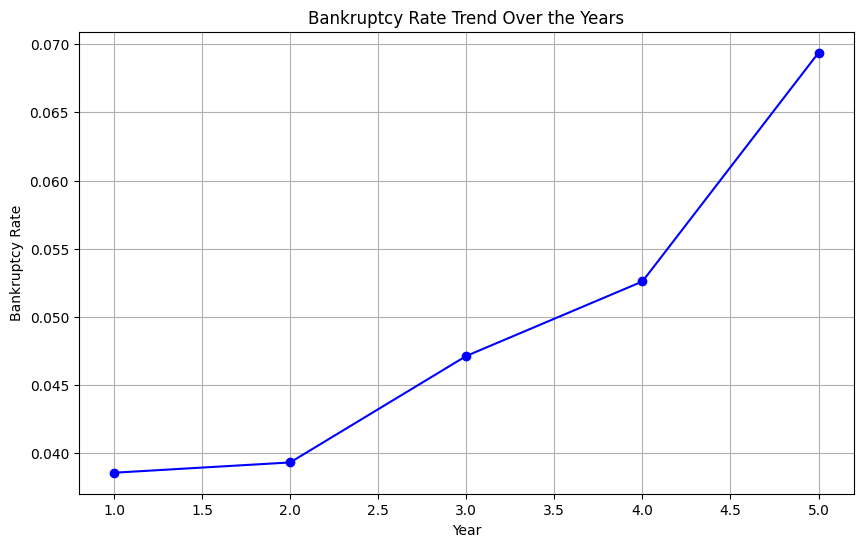

In [11]:
# Plotting the bankruptcy rate trend
plt.figure(figsize=(10, 6))
plt.plot(bankruptcy_rate_per_year.index, bankruptcy_rate_per_year.values, marker='o', linestyle='-', color='b')
plt.title('Bankruptcy Rate Trend Over the Years')
plt.xlabel('Year')
plt.ylabel('Bankruptcy Rate')
plt.grid(True)
plt.show()

### Split

In [12]:
target = "class"
X = df.drop(columns=[target, "year"])
y = df[target]
print("X shape:", X.shape)
print("y shape:", y.shape)

X shape: (43405, 64)
y shape: (43405,)


In [13]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

print("X_train shape:", X_train.shape)
print("y_train shape:", y_train.shape)
print("X_test shape:", X_test.shape)
print("y_test shape:", y_test.shape)

X_train shape: (34724, 64)
y_train shape: (34724,)
X_test shape: (8681, 64)
y_test shape: (8681,)


#### Resample

In [14]:
over_sampler = RandomOverSampler(random_state=42)
X_train_over, y_train_over = over_sampler.fit_resample(X_train, y_train)
print("X_train_over shape:", X_train_over.shape)

X_train_over shape: (66148, 64)


### Build Model

#### Baseline

In [15]:
acc_baseline = y_train.value_counts(normalize=True).max()
print("Baseline Accuracy:", round(acc_baseline, 4))

Baseline Accuracy: 0.9525


In [16]:
clf = make_pipeline(
    SimpleImputer(), GradientBoostingClassifier()
)
print(clf)

Pipeline(steps=[('simpleimputer', SimpleImputer()),
                ('gradientboostingclassifier', GradientBoostingClassifier())])


In [17]:
params = {
    "simpleimputer__strategy": ["mean", "median"],
    "gradientboostingclassifier__n_estimators": range(20, 31, 5),
    "gradientboostingclassifier__max_depth": range(2, 5)
}
params

{'simpleimputer__strategy': ['mean', 'median'],
 'gradientboostingclassifier__n_estimators': range(20, 31, 5),
 'gradientboostingclassifier__max_depth': range(2, 5)}

In [18]:
model = GridSearchCV(
    clf, param_grid=params, cv=5, n_jobs=-1, verbose=1
)

In [19]:
# Train model
model.fit(X_train_over, y_train_over)

Fitting 5 folds for each of 18 candidates, totalling 90 fits


GridSearchCV(cv=5,
             estimator=Pipeline(steps=[('simpleimputer', SimpleImputer()),
                                       ('gradientboostingclassifier',
                                        GradientBoostingClassifier())]),
             n_jobs=-1,
             param_grid={'gradientboostingclassifier__max_depth': range(2, 5),
                         'gradientboostingclassifier__n_estimators': range(20, 31, 5),
                         'simpleimputer__strategy': ['mean', 'median']},
             verbose=1)

In [20]:
cv_results = pd.DataFrame(model.cv_results_)
cv_results.head(10)

,mean_fit_time,std_fit_time,mean_score_time,std_score_time,param_gradientboostingclassifier__max_depth,param_gradientboostingclassifier__n_estimators,param_simpleimputer__strategy,params,split0_test_score,split1_test_score,split2_test_score,split3_test_score,split4_test_score,mean_test_score,std_test_score,rank_test_score
0,14.449834,0.745015,0.048961,0.014574,2,20,mean,"{'gradientboostingclassifier__max_depth': 2, '...",0.778912,0.781557,0.784732,0.784715,0.778592,0.781702,0.002673,15
1,15.023575,0.416629,0.031510,0.006833,2,20,median,"{'gradientboostingclassifier__max_depth': 2, '...",0.762434,0.769463,0.767271,0.762114,0.764835,0.765223,0.002820,18
2,18.072851,0.334262,0.031602,0.007785,2,25,mean,"{'gradientboostingclassifier__max_depth': 2, '...",0.785790,0.786243,0.794407,0.790082,0.783430,0.787991,0.003853,14
3,18.559313,0.253870,0.045982,0.033941,2,25,median,"{'gradientboostingclassifier__max_depth': 2, '...",0.771202,0.775435,0.773847,0.771789,0.770807,0.772616,0.001756,17
4,22.636027,0.517777,0.033408,0.005286,2,30,mean,"{'gradientboostingclassifier__max_depth': 2, '...",0.795692,0.793424,0.800378,0.795601,0.790158,0.795050,0.003337,13
5,22.840990,0.518399,0.031264,0.004694,2,30,median,"{'gradientboostingclassifier__max_depth': 2, '...",0.779214,0.782389,0.780877,0.779726,0.781011,0.780643,0.001106,16
6,22.154277,0.744012,0.028212,0.001041,3,20,mean,"{'gradientboostingclassifier__max_depth': 3, '...",0.824943,0.830159,0.827740,0.831204,0.824628,0.827735,0.002659,11
7,23.398370,1.349233,0.032210,0.003176,3,20,median,"{'gradientboostingclassifier__max_depth': 3, '...",0.820106,0.825170,0.823961,0.823418,0.814801,0.821491,0.003742,12
8,30.972367,0.798801,0.034823,0.004093,3,25,mean,"{'gradientboostingclassifier__max_depth': 3, '...",0.832729,0.837642,0.830990,0.837251,0.831355,0.833993,0.002881,9
9,31.436788,1.032443,0.035452,0.006682,3,25,median,"{'gradientboostingclassifier__max_depth': 3, '...",0.829327,0.836432,0.831822,0.830221,0.823569,0.830274,0.004151,10


In [21]:
# Extract best hyperparameters
model.best_params_

{'gradientboostingclassifier__max_depth': 4,
 'gradientboostingclassifier__n_estimators': 30,
 'simpleimputer__strategy': 'median'}

### Evaluate 

In [22]:
acc_train = model.score(X_train_over, y_train_over)
acc_test = model.score(X_test, y_test)

print("Training Accuracy:", round(acc_train, 4))
print("Test Accuracy:", round(acc_test, 4))

Training Accuracy: 0.8768
Test Accuracy: 0.8615


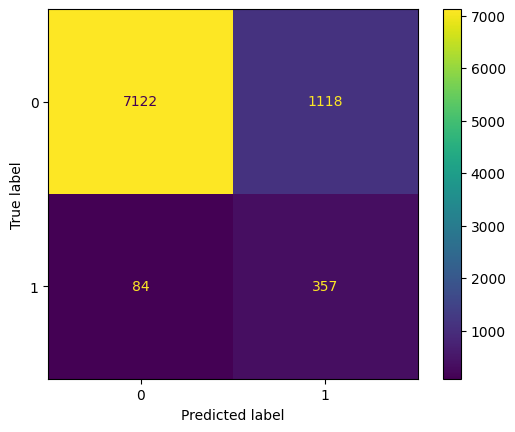

In [23]:
# Plot confusion matrix
ConfusionMatrixDisplay.from_estimator(model, X_test, y_test);

In [25]:
# Print classification report
print(classification_report(y_test, model.predict(X_test)))

              precision    recall  f1-score   support

           0       0.99      0.86      0.92      8240
           1       0.24      0.81      0.37       441

    accuracy                           0.86      8681
   macro avg       0.62      0.84      0.65      8681
weighted avg       0.95      0.86      0.89      8681



### Communicate

In [ ]:
# Save model
with open("model-5-3.pkl", "wb") as f:
    pickle.dump(model, f)